In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [13]:
# I'm setting up data transformations with normalization for better training stability
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# I'm loading the MNIST dataset for handwritten digit classification
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# I'm creating data loaders with appropriate batch sizes for efficient training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # I'm designing a CNN architecture with two convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 after two 2x2 pooling operations on 28x28
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9
        self.dropout = nn.Dropout(0.25)  # I'm adding dropout for regularization

    def forward(self, x):
        # I'm applying convolution, activation, and pooling layers
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        
        # I'm flattening the feature maps for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # I'm applying dropout during training
        x = self.fc2(x)
        return x

In [15]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    """I'm training the model for one epoch and tracking metrics"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # I'm tracking training metrics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [16]:
def test_model(model, test_loader, criterion):
    """I'm evaluating the model on test data and returning detailed metrics"""
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            
            # I'm collecting predictions for detailed analysis
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    
    return test_loss, accuracy, all_preds, all_targets

In [17]:
def visualize_predictions(model, test_loader, num_images=5):
    """I'm visualizing model predictions on sample images"""
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            
            # I'm creating a subplot for better visualization
            fig, axes = plt.subplots(1, min(num_images, len(data)), figsize=(15, 3))
            if num_images == 1:
                axes = [axes]
            
            for i in range(min(num_images, len(data))):
                img = data[i].cpu().numpy().squeeze()
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f'True: {target[i].item()}, Pred: {pred[i].item()}', 
                                fontsize=12, color='green' if target[i].item() == pred[i].item() else 'red')
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            break

In [18]:
def plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies):
    """I'm plotting training and validation metrics over epochs"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # I'm plotting loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss')
    ax1.set_title('Model Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # I'm plotting accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    ax2.set_title('Model Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [19]:
def analyze_model_performance(all_targets, all_preds):
    """I'm creating detailed performance analysis with confusion matrix"""
    # I'm generating a confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix for MNIST Classification')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
        # I'm printing detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_preds, 
                              target_names=[str(i) for i in range(10)]))


In [20]:
# I'm initializing my model, optimizer, and loss function
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# I'm tracking training history for visualization
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

print("Starting training...")
# I'm training the model for multiple epochs
for epoch in range(1, 6):  # 5 epochs for demonstration
    train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader, epoch)
    test_loss, test_acc, all_preds, all_targets = test_model(model, test_loader, criterion)
    
    # I'm storing metrics for later visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%\n")


Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295400
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.216580
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.355851
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.100180
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.122841
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.129992
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.066698
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.009356
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.070448
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.034548
Test set: Average loss: 0.0462, Accuracy: 9847/10000 (98.47%)
Epoch 1: Train Acc: 95.24%, Test Acc: 98.47%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051886
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.033342
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.013080
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.003524
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.033853
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.044539
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.037144
Train Epoch: 2 [44800/60000 (75%)

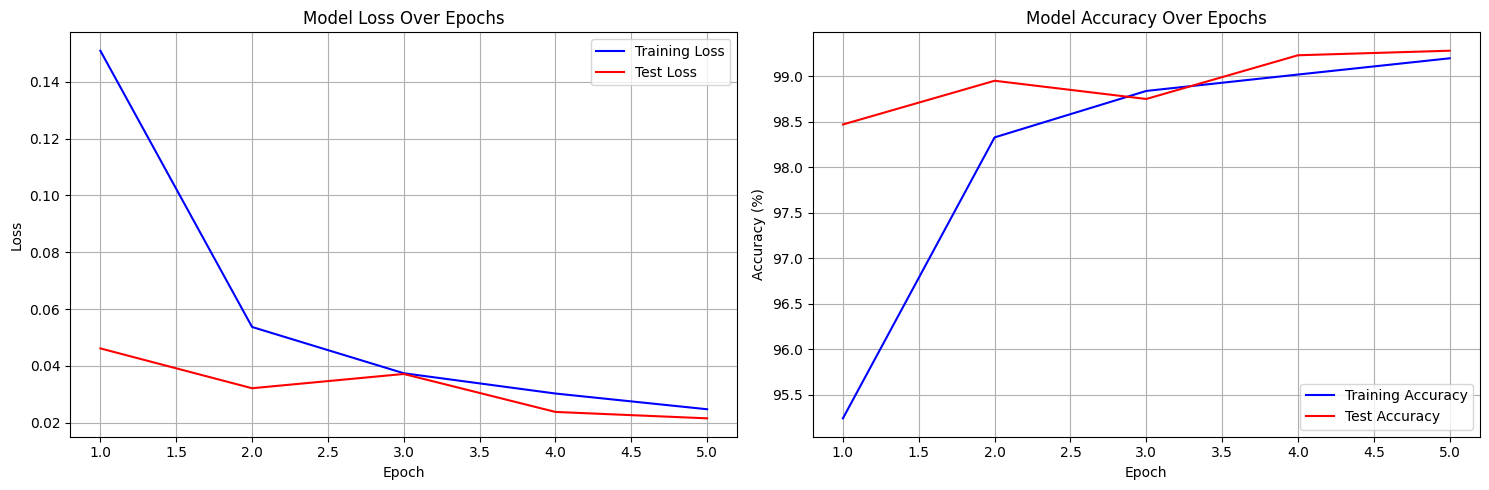

Sample Predictions:


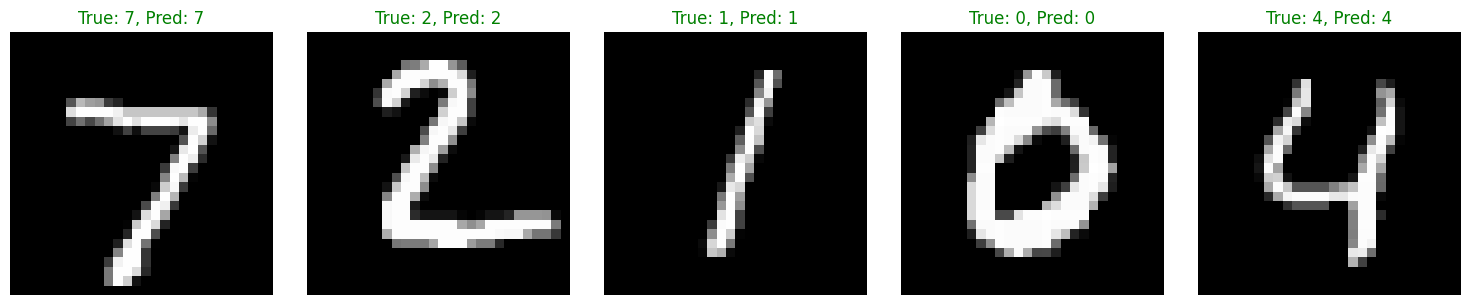

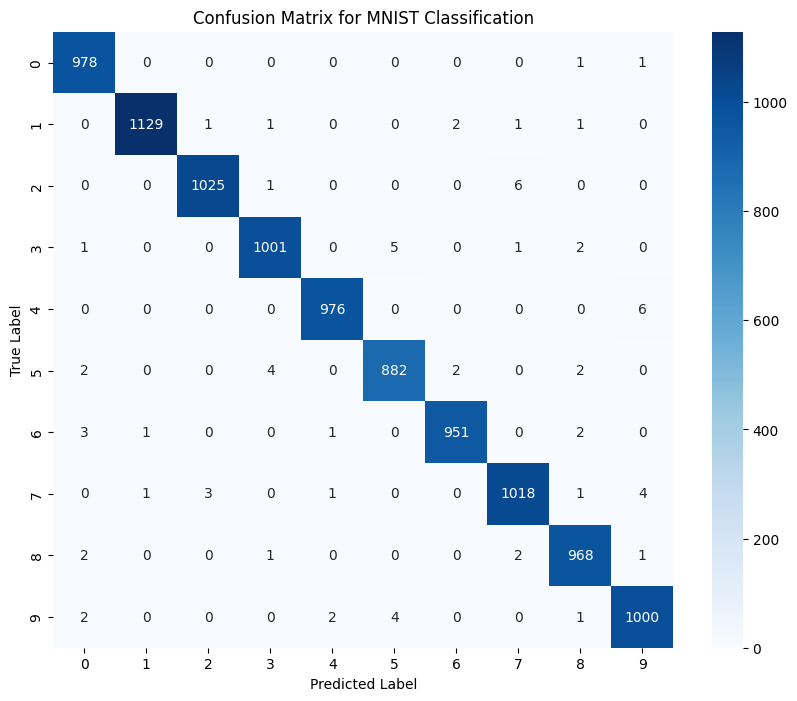


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [21]:
# I'm visualizing the training progress
plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies)

# I'm displaying sample predictions
print("Sample Predictions:")
visualize_predictions(model, test_loader, num_images=5)

# I'm performing detailed model analysis
analyze_model_performance(all_targets, all_preds)